<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#ML-Pipeline-Preparation" data-toc-modified-id="ML-Pipeline-Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>ML Pipeline Preparation</a></span><ul class="toc-item"><li><span><a href="#Import-libraries-and-load-data-from-database." data-toc-modified-id="Import-libraries-and-load-data-from-database.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import libraries and load data from database.</a></span></li><li><span><a href="#Write-a-tokenization-function-to-process-your-text-data" data-toc-modified-id="Write-a-tokenization-function-to-process-your-text-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Write a tokenization function to process your text data</a></span></li><li><span><a href="#Train-and-test-your-model" data-toc-modified-id="Train-and-test-your-model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Train and test your model</a></span><ul class="toc-item"><li><span><a href="#RandomForest-Classifier" data-toc-modified-id="RandomForest-Classifier-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>RandomForest Classifier</a></span></li><li><span><a href="#GridSearchCV-with-RandomForestClassifier" data-toc-modified-id="GridSearchCV-with-RandomForestClassifier-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>GridSearchCV with RandomForestClassifier</a></span></li><li><span><a href="#High-scores-on-fitting-data,-but-let-a-closer-look" data-toc-modified-id="High-scores-on-fitting-data,-but-let-a-closer-look-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>High scores on fitting data, but let a closer look</a></span></li></ul></li><li><span><a href="#XGBoost" data-toc-modified-id="XGBoost-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>XGBoost</a></span></li><li><span><a href="#GridSearch-with-XGBoost" data-toc-modified-id="GridSearch-with-XGBoost-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>GridSearch with XGBoost</a></span></li><li><span><a href="#Try-improving-your-model-further.-Here-are-a-few-ideas:" data-toc-modified-id="Try-improving-your-model-further.-Here-are-a-few-ideas:-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Try improving your model further. Here are a few ideas:</a></span><ul class="toc-item"><li><span><a href="#5.-Export-your-model-as-a-pickle-file" data-toc-modified-id="5.-Export-your-model-as-a-pickle-file-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>5. Export your model as a pickle file</a></span></li><li><span><a href="#10.-Use-this-notebook-to-complete-train.py" data-toc-modified-id="10.-Use-this-notebook-to-complete-train.py-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>10. Use this notebook to complete <code>train.py</code></a></span></li></ul></li></ul></li></ul></div>

# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
## Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [49]:
# filter warning message
import warnings
warnings.filterwarnings('ignore')

In [50]:
# import libraries
import time
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

In [51]:
# load data from database
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql("SELECT * FROM message_response", con=engine)
df.isnull().any().sum()

0

In [52]:
# convert category column data type from int64 to int8
for column in df.columns[2:]:
    df[column] = df[column].astype('int8')

In [53]:
# and message from object to string
df['message'] = df['message'].astype(str)

In [54]:
# split features and labels
X = df['message'].values
Y = df.drop(['message', 'genre'], axis=1).copy().values

In [55]:
X.shape

(26215,)

In [56]:
# with 36 categories
Y.shape

(26215, 36)

## Write a tokenization function to process your text data

In [57]:
# import libraries for NLTK
import re
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
# stopwords.words('english')

[nltk_data] Downloading package punkt to /home/uno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/uno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/uno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/uno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
# libraries for sklearn
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, KFold

In [59]:
def tokenize(text):
    '''Process text to lower case, remove stopwords, and lemmatize.

    Input: A line of text
    Return: a list of words (tokens)
    '''
        
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    tokens = word_tokenize(text)
    
    tokens = [w for w in tokens if w not in stopwords.words('english')]
    
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)
    return clean_tokens

## Train and test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [60]:
# print out scores with `classification_report`
# three types of scores: 
# 1. precision -- portion of the corectly classified to the total classified
# 2. recall -- portion of the corectly classified to the total items should be corectly classified
# 3. f1-score -- weighted balance of recall and precision
# more on these: https://en.wikipedia.org/wiki/F-score

labels = df.columns[2:]
def test_report(Y_predict, Y_test, verbose=False):
    '''return a dictionary of scores from classification report'''
    
    scores = dict()
    for i in range(len(labels)):
        report = classification_report(Y_predict[:, i], Y_test[:, i], 
                                           output_dict=True)
        if verbose:
            scores.update({labels[i]: report})
        else:
            scores.update({labels[i]: report['weighted avg']})
    return scores

In [61]:
def quick_eval(model):
    '''evaluate predicting score on testing data'''
    
    Y_predict = model.predict(X_test)
    scores = test_report(Y_predict, Y_test)
    df_scores = pd.DataFrame.from_dict(data=scores, orient='index')
    print(df_scores.mean(axis=0))
    return df_scores

In [14]:
# with Pipeline only, no GridSearch
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])
pipeline_knn.fit(X_train, Y_train)
quick_eval(pipeline_knn)

precision        0.972016
recall           0.935550
f1-score         0.951009
support      18351.000000
dtype: float64


,precision,recall,f1-score,support
related,0.857367,0.780884,0.809870,18351
request,0.902951,0.869162,0.881873,18351
offer,1.000000,0.995586,0.997788,18351
aid_related,0.749169,0.673369,0.693865,18351
medical_help,0.984874,0.919023,0.949043,18351
medical_products,0.992506,0.951174,0.969859,18351
search_and_rescue,0.998447,0.974334,0.985878,18351
security,0.999726,0.982944,0.991237,18351
military,0.995645,0.968612,0.981178,18351
child_alone,1.000000,1.000000,1.000000,18351


In [14]:
# experiment with GridSearchCV and parameters

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_knn = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])
parameters = {
#         'vect__stop_words': (None, 'english'),
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 100, 1000, 10000),
        'tfidf__use_idf': (True, False),
#         'tfidf__smooth_idf': (True, False),
#         'tfidf__sublinear_tf': (True, False),
        'clf__estimator__n_neighbors': [3, 5, 10, 20],
#         'clf__estimator__weights': ['uniform', 'distance'],
#         'clf__estimator__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#         'clf__estimator__leaf_size': [1,10,30,50],
#         'clf__estimator__p': [1,2,3]
    }
cv = GridSearchCV(pipeline_knn, param_grid=parameters, cv=3, verbose=True, n_jobs=-1)

start = time.time()
cv.fit(X_train, Y_train)
last_for = time.time() - start
print(f'Total training time: {last_for:.1f} seconds')

Fitting 3 folds for each of 192 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed: 36.5min finished


Total training time: 2206.5 seconds


In [21]:
# see what the best parameters for fitting so far
cv.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.5,
                                 max_features=1000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at 0x7fa9371e6510>,
                                 vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto',

In [15]:
quick_eval(cv)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


precision        0.973828
recall           0.937855
f1-score         0.953120
support      18351.000000
dtype: float64


,precision,recall,f1-score,support
related,0.739005,0.743720,0.740270,18351
request,0.918611,0.882731,0.895428,18351
offer,1.000000,0.995586,0.997788,18351
aid_related,0.786715,0.695820,0.718781,18351
medical_help,0.997494,0.919568,0.956530,18351
medical_products,0.999180,0.949158,0.973278,18351
search_and_rescue,1.000000,0.973898,0.986776,18351
security,1.000000,0.982998,0.991426,18351
military,1.000000,0.967849,0.983662,18351
child_alone,1.000000,1.000000,1.000000,18351


In [16]:
# using trained model to predict on test data 
Y_predict = cv.predict(X_test)

In [17]:
Y_predict.shape

(18351, 36)

In [18]:
scores = test_report(Y_predict, Y_test)

In [40]:
def visualize_report(score_report, title='Scores on test data'):
    '''visualize score report by matplotlib'''
    
    if isinstance(score_report, dict):
        df_scores = pd.DataFrame.from_dict(data=scores, orient='index')
    else:
        df_scores = score_report
    fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
    width = 0.2
    score_types = ['precision', 'recall', 'f1-score']
    x = np.arange(0, len(df_scores))
    for i, label in enumerate(score_types):
        ax.bar(x+i*width, df_scores[label], width=width, label=label)
    ax.set_xlim(0, len(df_scores))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    cat_labels = list(df_scores.index)
    cat_labels.insert(0,'')
    ax.set_title(title)
    ax.set_xticklabels(cat_labels, rotation=90)
    fig.legend(ncol=3, loc='lower center')
    fig.tight_layout()
    fig.savefig('models/evaluate_score.png');
    return None

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()


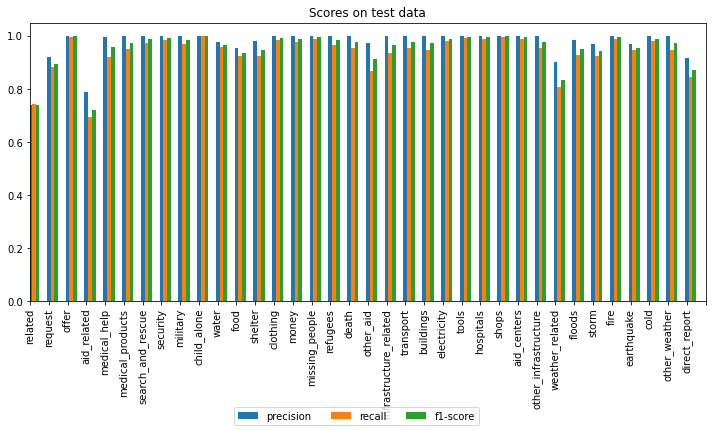

In [21]:
visualize_report(scores)

### RandomForest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
# with Pipeline only, no GridSearch
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_jobs=-1, verbose=False)))
])
pipeline_rf.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [17]:
quick_eval(pipeline_rf)

precision        0.976734
recall           0.947006
f1-score         0.960047
support      18351.000000
dtype: float64


,precision,recall,f1-score,support
related,0.877935,0.808566,0.833107,18351
request,0.922274,0.893139,0.903201,18351
offer,1.000000,0.995586,0.997788,18351
aid_related,0.781879,0.775707,0.777606,18351
medical_help,0.989000,0.920222,0.951681,18351
medical_products,0.996727,0.949866,0.971917,18351
search_and_rescue,0.999076,0.974007,0.986201,18351
security,0.999670,0.982835,0.991181,18351
military,0.998650,0.968231,0.982873,18351
child_alone,1.000000,1.000000,1.000000,18351


### GridSearchCV with RandomForestClassifier

In [ ]:
# experiment with GridSearchCV and parameters
# aborted after running too long

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])
parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
        'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 100, 1000, 10000),
        'tfidf__use_idf': (True, False),
        'clf__estimator__n_estimators': [50, 100, 200, 500],
        'clf__estimator__bootstrap': [True, False]
    }
cv = GridSearchCV(pipeline_rf, param_grid=parameters, cv=3, verbose=True, n_jobs=-1)

start = time.time()
cv.fit(X_train, Y_train)
last_for = time.time() - start
print(f'Total training time: {last_for:.1f} seconds')

Fitting 3 folds for each of 384 candidates, totalling 1152 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 50.3min


In [29]:
quick_eval(cv)

precision        0.972370
recall           0.948167
f1-score         0.958881
support      18351.000000
dtype: float64


,precision,recall,f1-score,support
related,0.830015,0.803771,0.814256,18351
request,0.918815,0.893139,0.902157,18351
offer,0.999891,0.995532,0.997706,18351
aid_related,0.767917,0.765789,0.766604,18351
medical_help,0.986815,0.921748,0.950922,18351
medical_products,0.991743,0.952155,0.969755,18351
search_and_rescue,0.997278,0.974770,0.985287,18351
security,0.999121,0.982562,0.990772,18351
military,0.996104,0.968612,0.981441,18351
child_alone,1.000000,1.000000,1.000000,18351


### High scores on fitting data, but let a closer look

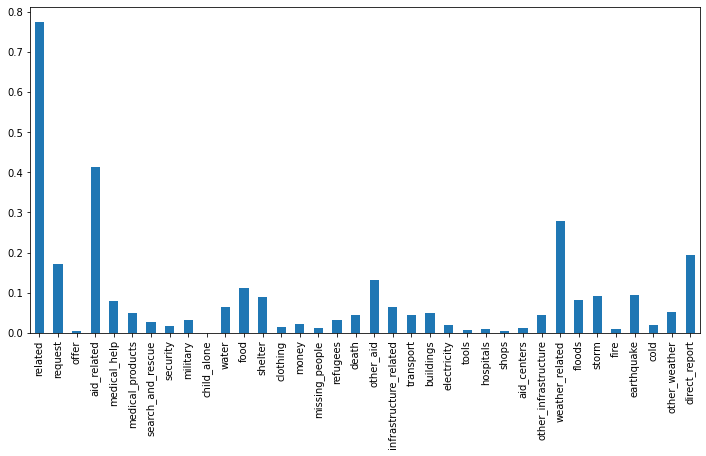

In [20]:
# imbalanced dataset, most of columns containing data for 0
# high fitting score, but not very useful to identify a positive message 
fig, ax = plt.subplots(figsize=(12,6))
df[df.columns[2:]].mean().plot(kind='bar', ax=ax);

## XGBoost

In [62]:
from xgboost import XGBClassifier

In [63]:
# with Pipeline only, no GridSearch
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_xgb = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(XGBClassifier()))
])
pipeline_xgb.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                               learning_rate=None,
                                                               max_delta_step=None,
                                                               max_depth=None,
                                                               min_child_weight=None,
   

In [64]:
scores = quick_eval(pipeline_xgb)
scores

precision        0.965628
recall           0.949031
f1-score         0.955863
support      18351.000000
dtype: float64


,precision,recall,f1-score,support
related,0.872015,0.809002,0.831344,18351
request,0.913451,0.895646,0.902154,18351
offer,0.999782,0.995477,0.997625,18351
aid_related,0.783794,0.767206,0.771508,18351
medical_help,0.961699,0.926271,0.940918,18351
medical_products,0.977981,0.955970,0.964975,18351
search_and_rescue,0.987843,0.974334,0.980276,18351
security,0.996293,0.982017,0.988898,18351
military,0.980309,0.969593,0.974204,18351
child_alone,1.000000,1.000000,1.000000,18351


## GridSearch with XGBoost

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=1)
pipeline_xgb = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(XGBClassifier()))
])
parameters = {
        'vect__ngram_range': ((1, 1), (1, 2)),
#         'vect__max_df': (0.5, 0.75, 1.0),
        'vect__max_features': (None, 100, 1000, 10000),
        'tfidf__use_idf': (True, False),
        'clf__estimator__n_estimators': [50, 100, 200],
#         'clf__estimator__max_depth': [3, 5, 10]
    }

kfold = KFold(n_splits=10, random_state=1)
clf_xgb = GridSearchCV(pipeline_xgb, param_grid=parameters, cv=kfold, verbose=1, n_jobs=-1)

start = time.time()
clf_xgb.fit(X_train, Y_train)
last_for = time.time() - start
print(f'Total training time: {last_for:.1f} seconds')

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed: 61.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 75.0min finished


Total training time: 4875.6 seconds


In [67]:
scores = quick_eval(clf_xgb)
scores

precision        0.960229
recall           0.947463
f1-score         0.952870
support      18351.000000
dtype: float64


,precision,recall,f1-score,support
related,0.833798,0.808675,0.818687,18351
request,0.895530,0.887200,0.890677,18351
offer,0.999454,0.995314,0.997379,18351
aid_related,0.781561,0.765190,0.769473,18351
medical_help,0.956681,0.926108,0.938763,18351
medical_products,0.973959,0.953735,0.962184,18351
search_and_rescue,0.985062,0.973789,0.978756,18351
security,0.993304,0.980655,0.986759,18351
military,0.977503,0.967250,0.971781,18351
child_alone,1.000000,1.000000,1.000000,18351


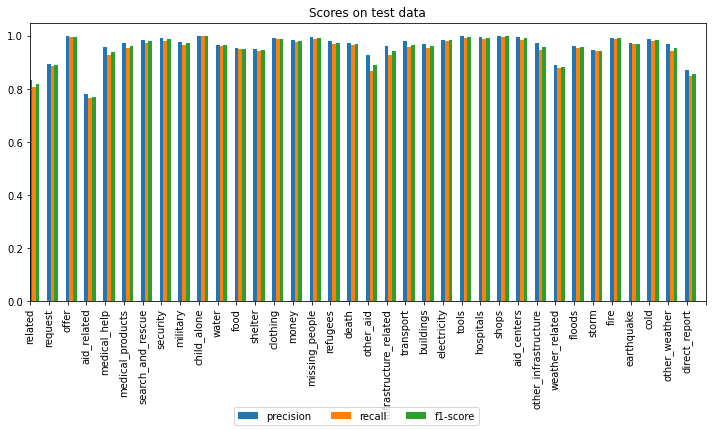

In [68]:
visualize_report(scores)

In [77]:
with open('models/evaluate_score_xgb.txt', 'w+') as f:
    f.write(json.dumps(scores.to_dict(orient='index')))

## Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

In [32]:
# we can try another classifer
from sklearn.ensemble import RandomForestClassifier

In [33]:
pipeline_rf = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

In [34]:
pipeline_rf.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

In [35]:
quick_eval(pipeline_rf)

precision        0.977239
recall           0.923438
f1-score         0.947745
support      18345.000000
dtype: float64


,precision,recall,f1-score,support
related,0.927932,0.748814,0.822905,18345
request,0.948039,0.823712,0.877158,18345
offer,1.000000,0.995312,0.997651,18345
aid_related,0.654177,0.561297,0.592377,18345
medical_help,0.995930,0.917852,0.955134,18345
medical_products,0.998993,0.949578,0.973659,18345
search_and_rescue,0.999668,0.971763,0.985518,18345
security,0.999836,0.982775,0.991205,18345
military,0.999724,0.968220,0.983692,18345
child_alone,1.000000,1.000000,1.000000,18345


In [30]:
cv.best_estimator_

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.75,
                                 max_features=1000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize a...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

### 5. Export your model as a pickle file

In [70]:
import joblib

In [ ]:
# joblib.dump(pipeline_knn, 'models/knn_clf_v1.pkl')

In [73]:
joblib.dump(clf_xgb, 'models/xgb_clf.pkl', compress=3)

['models/xgb_clf.pkl']

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.